# Support Vector Machines

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## SVMのモチベーション
ベイズ分類の議論の部分でそれぞれのクラス下における分布を説明するシンプルなモデルを学び、そして新しい点に対するラベルを決定する確率に対するそれらの生成モデルを使用した。それらは生成モデル分類の例であった。ここではかわりに識別モデル分類について考える。それぞれのクラスのモデリングをするのではなく、それぞれ互いにクラスを分ける直線や曲線（2次元）や多様体（多次元）を単に探す。

これの例として、分類問題のシンプルな例を考え、そこでは2つのクラスの点が分布している。

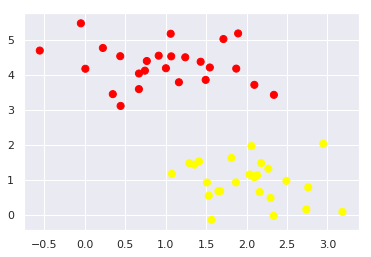

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

線形分類器は2セットのデータを分ける直線を描くことを試みる。そしてそれにより、分類を行うモデルを作成する。ここで示されているような2次元のデータに対して、これは手で行うことが出来るような問題である。しかし、すぐに問題に気づく。2つのクラスの間を完全に区別することが出来る直線は1つでないことである。

それらを以下で描画する。

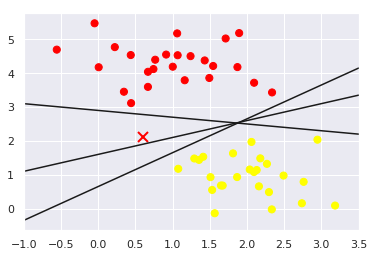

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

3つの異なる直線があるが、いずれも完全にそれらのサンプルを区別する。新しいデータ点をどこにとるかによって、その点は異なるラベルに割り当てられる（このプロットでは"X"で記された点）。明らかに、クラス間に直線を描くというシンプルな直感では不十分であり、より深く考える必要がある。

## SVM: マージンを最大化する
SVMはこのことを改善する一つの方法を提供する。直感的にはこれは、クラス間に幅0の線を単に描くのではなく、それぞれの線の周りに、近傍点までのいくらかの幅のマージンを描く。これがどのように見えるかが次の例である。

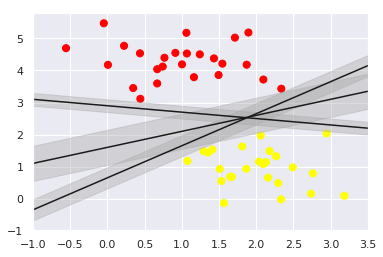

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

SVMではこのマージンを最大化する直線が適切なモデルとして選ぶものである。SVMはマージン最大化を推定する一つの例である。

### SVMのフィッティング
このデータに対する実際のフィットの結果を確認しよう。このデータに対するSVMモデルを学習するのにScikit-Learnのsupport vector classifierを利用する。当面、線形カーネルを使用し、`C`パラメータは非常に大きな値を設定する。

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

何が起こっているかよりよく可視化するために、SVMが決定した境界をプロットをする便利な関数を作成する。

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',
                   edgecolors="black");
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

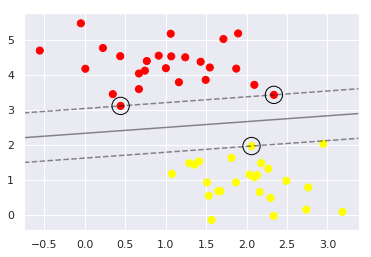

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

これが2セットの点の間でマージンを最大化する分割線である。マージンに触れる学習点が少ないことに気づく。それらは図の中で黒い円で指し示られている。これらの点はこのフィットの極めて重要な要素であり、サポートベクターとして知られ、それはこのアルゴリズムの名前でもある。Scikit-Learnでは分類器のアトリビュートの`support_vectors_`の中にこれらの点を示すものが保存されている。

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

この分類器が成功するための鍵は、このフィットに対してサポートベクターの位置だけが重要であるということだ。マージンから遠く離れたいずれの点もフィットを変更しない。技術的にはこれらの点がこのモデルをフィットするのに使用される損失関数になにも寄与しないからである、そのため、マージンを超えない限り、その位置と数は重要ではない。

例えば、始めの60点から学んだモデルと、始めの120点から学んだモデルをプロットすればこれが分かる。

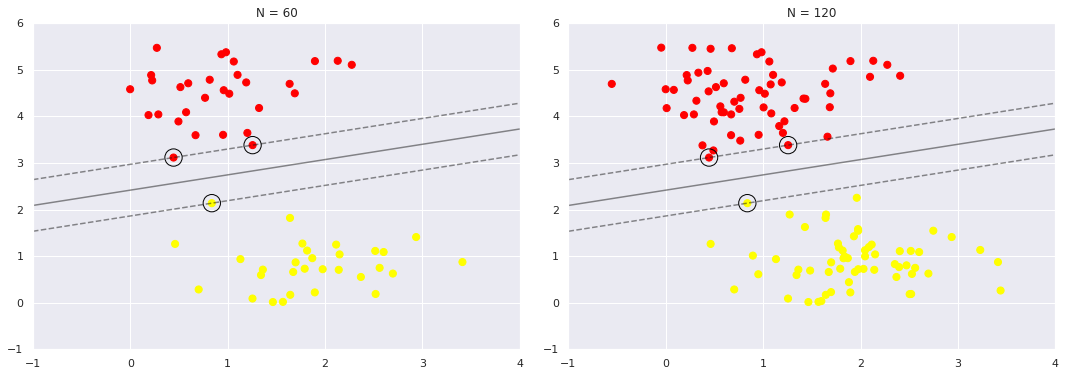

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

左図では、モデルと60点の学習点に対するサポートベクターが分かる。右図では学習点が2倍となっているが、モデルは変わっていない。左図の3つのサポートベクターは右図でもおいてもなおサポートベクターとなっている。この遠い点の実際の振る舞いに対する鈍感さはSVMモデルの強さの一つである。

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### 線形な境界を超える：カーネルSVM
SVMがとてもパワフルになるのは、それがカーネルと結びついた時である。我々は線形回帰の基底関数回帰においてカーネルのバージョンを見ている。そこでは、データを多項式やガウス基底関数によって定義される高次元空間に射影した。それによって、線形分類器で非線形の関係性をフィットすることが出来るようになった。

SVMモデルでは同じアイデアのバージョンを使用することができる。カーネルの必要性を考えるために、線形分離できないデータを見てみる。

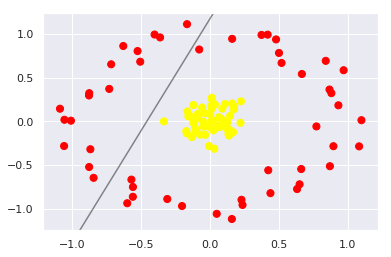

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

直線の分割によってこのデータを分けることは出来ないことは明らかである。しかい、線形回帰で学んだように、どのようにして直線の分割で十分なように高次元にデータを射影するか考えることが出来る。例えば、私たちが使うことができる簡単な射影の1つは、中央の群集を中心とする放射基底関数を計算することです。

In [12]:
r = np.exp(-(X ** 2).sum(1))

この追加のデータを三次元プロットで可視化することが出来る。

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    

interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

この追加の次元があれば、データは例えばr=0.7の平面によって容易に線形分離になることが分かる。

ここで、射影は注意して調整し、選択する必要があった。もし、放射基底関数を正しい位置に中心を持って行かんかったならば、このようにきれいに線形分離可能な結果を得ることが出来なかっただろう。一般的に、そのような選択を行うことが問題となる。私たちは何とか自動的に最良の基底関数を見つけることを望みます。

このための一つの戦略は、データセットの全ての点上を基底関数の中心として計算し、SVMアルゴリズムがその結果をふるいにかけるようにすることである。この種の基底関数の変換はカーネル変換としてしられ、それは点のペアの間の似たような関係性（カーネル）を基礎とする。

この戦略が潜在的に抱える問題は、N点をN次元に射影することであり、それはNの数が大きくなるほど計算コストが高くなるだろう。しかしながら、カーネルトリックとして知られる整然とした小さな手続きにより、カーネル変換されたデータへのフィットが厳密に行える。それはつまり、カーネル射影のN次元の完全な表現を構築することなくおこなえる。このカーネルトリックはSVMに組み込まれており、このメソッドが強力な理由の一つであり。

Scikit-Learnでは、`kernel`モデルは`kernel`モデルハイパーパラメータを利用して、線形カーネルをRBF(radial basis function)カーネルに変更するだけでカーネル化したSVMを適用できる。

In [14]:
clf = SVC(kernel='rbf', C=1E6, gamma="auto")
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

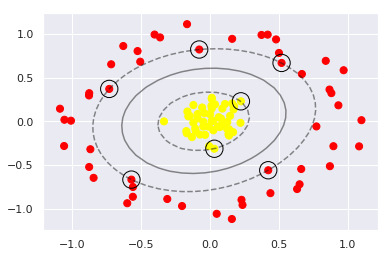

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### SVMのチューニング：ソフトマージン
これまでの議論ではきれいなデータセットの中心があった。そこでは明確な境界が存在した。しかし、もしいくつかのオーバーラップがデータにあったらどうだろうか。たとえば次のようなデータである。

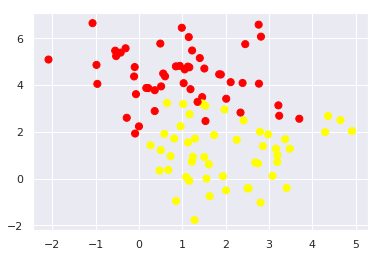

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

この場合を扱うために、マージンを柔軟にするファッジファクターをSVMの実装は持っている。それはつまり、より良いフィットを行うために、マージンの中に点が入り込むことを許すことである。マージンの堅さはCとして知られるチューニングパラメータによって制御される。とても大きなCに対して、マージンは堅く、点はマージンの中に入り込まない。より小さいCにたいして、マージンはより柔軟となり、いくつかの点はマージンの中に入り込む。

次のプロットはCパラメータを変更すると最終的なフィットにどれだけ影響するかを示す。

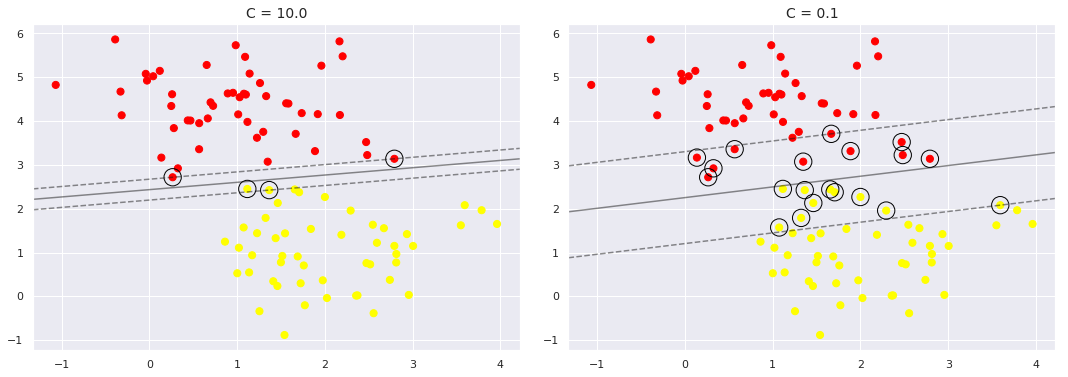

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

最適なCパラメータはデータセットに依存するため、クロスバリデーションなどでチューニングすべきである。

## 例：顔認識

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


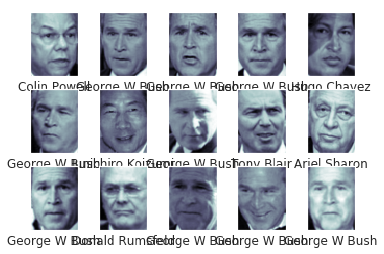

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

それぞれのイメージは62x47で3000ピクセル程度含んでいる。特徴としてそれぞれの点を単に使用して進めることも出来るが、より意味のある特徴を取り出す前処理を使用することがしばしばより効率的である。ここでは主要因貝瀬によって150のいみのある要因を取り出し、SVMに与える。

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

トレーニングセットとテストセットに分ける。

In [21]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

最後に、パラメータの組み合わせを探るために、クロスバリデーションを使用する。ここではCとgammaを調整する。

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=3, iid=True)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 53.9 s, sys: 3.2 s, total: 57.1 s
Wall time: 32.1 s
{'svc__C': 10, 'svc__gamma': 0.001}


In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

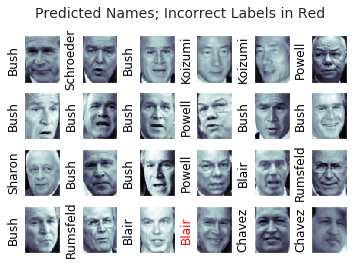

In [24]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [25]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



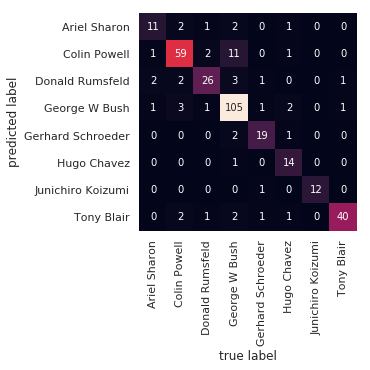

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

実際に世界では、こんなにきれいに顔の部分を切り取った写真ばかりでない。部分の切り取りではOpenCnなどが役に立つ。

## SVMまとめ
- 比較的少ないサポートベクターへの依存はそれらがとてもコンパクトなモデルであることを意味し、占有するメモリーがとても小さいことを意味する
- 一度モデルが学習されれば、予測はとても速い
- マージンの近くの点によってしか影響されないため、高次元のデータに対してもうまく動作する。それがたとえサンプル数より次元数の方が多いような、他のアルゴリズムにとっては挑戦的であったとしてもである。
- カーネル関数を統合することはそれらをとても多目的にし、多くのタイプのデータに適応することが出来る。

しかしながら、SVMはいくつかの欠点も持つ。

- サンプル数Nに応じて計算量は$O(N^3)$、効率的な実装であっても$O(N^2)$となる。大きな学習点であれば、この計算コストは桁違いとなる
- 結果はソフトマージンパラメータのCの適切な選択に大きく依存する。これはクロスバリデーションによって慎重に選ばれるべきであり、データセットが大きくなるほど、コストが高くなる。
- 結果は直接的な確率的解釈を持たない。これは内部クロスバリデーションによって見積もることが出来るが、この余分な見積もりはコストが高い（`SVC`の`probability`パラメータを参照）。